In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


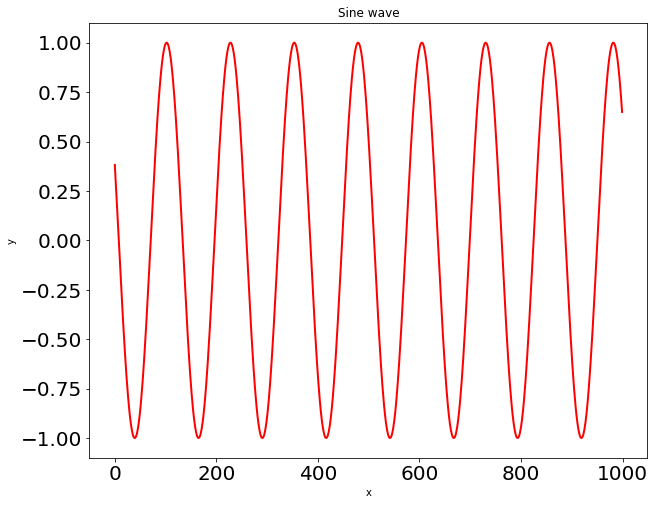

In [9]:
# Create parameters

N = 6
L = 1000
T = 20

x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
y = np.sin(x/1.0/T).astype(np.float32)



plt.figure(figsize = (10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:],'r', linewidth=2.0)
plt.show()

x = 5

In [12]:
# LSTM Class

class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future):
            print(output)
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs



Step 0
loss nan
tensor([[0.0442],
        [0.0462],
        [0.0621]])
tensor([[0.0467],
        [0.0480],
        [0.0600]])
tensor([[0.0486],
        [0.0495],
        [0.0582]])
tensor([[0.0498],
        [0.0504],
        [0.0568]])
tensor([[0.0506],
        [0.0511],
        [0.0558]])
tensor([[0.0512],
        [0.0515],
        [0.0551]])
tensor([[0.0516],
        [0.0518],
        [0.0545]])
tensor([[0.0519],
        [0.0521],
        [0.0540]])
tensor([[0.0522],
        [0.0523],
        [0.0536]])
tensor([[0.0523],
        [0.0524],
        [0.0534]])
tensor([[0.0525],
        [0.0525],
        [0.0532]])
tensor([[0.0526],
        [0.0526],
        [0.0530]])
tensor([[0.0526],
        [0.0527],
        [0.0529]])
tensor([[0.0527],
        [0.0527],
        [0.0529]])
tensor([[0.0527],
        [0.0527],
        [0.0528]])
tensor([[0.0527],
        [0.0527],
        [0.0528]])
tensor([[0.0527],
        [0.0528],
        [0.0528]])
tensor([[0.0528],
        [0.0528],
        [0.05

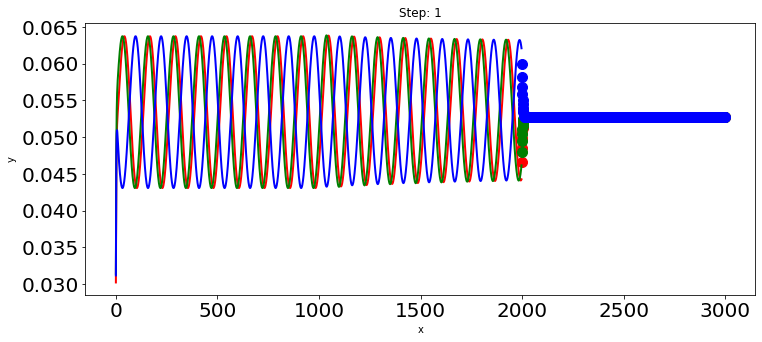

In [14]:
# Training Loop
# y = 100, 1000
train_input = torch.from_numpy(y[3:,:-1]) # 97, 999
train_target = torch.from_numpy(y[3:,1:]) # 97, 999 Target is the training data shifted by 1 into the future
test_input = torch.from_numpy(y[:3,:-1]) # 3, 999
test_target = torch.from_numpy(y[:3,1:]) # 3, 999

model = LSTMPredictor()
criterion = nn.MSELoss()

optimizer = optim.LBFGS(model.parameters(), lr=0.8)

n_steps = 1
for i in range(n_steps):
    print("Step", i)

    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        print("loss", loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)

    with torch.no_grad():
        future=1000
        pred = model(test_input, future=future)
        loss = criterion(pred[:,:-future], test_target)
        print("test loss", loss.item())
        y = pred.detach().numpy()

   
    plt.figure(figsize=(12,5))
    plt.title(f"Step: {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    n = train_input.shape[1] # 999
    def draw(y_i, color):
        plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
        plt.plot(np.arange(n, n+future), y_i[n:], color+"o", markersize=10)
    draw(y[0],'r')
    draw(y[1],'g')
    draw(y[2],'b')

    plt.savefig(f"images/step_{i+1}.png")

In [6]:
len(y[0])

1999

In [24]:
train_input.split(1,dim=1)

(tensor([[-0.3350],
         [ 0.7833],
         [-0.7115]]),
 tensor([[-0.3817],
         [ 0.8134],
         [-0.7457]]),
 tensor([[-0.4274],
         [ 0.8415],
         [-0.7781]]),
 tensor([[-0.4720],
         [ 0.8674],
         [-0.8085]]),
 tensor([[-0.5155],
         [ 0.8912],
         [-0.8369]]),
 tensor([[-0.5577],
         [ 0.9128],
         [-0.8632]]),
 tensor([[-0.5985],
         [ 0.9320],
         [-0.8874]]),
 tensor([[-0.6378],
         [ 0.9490],
         [-0.9093]]),
 tensor([[-0.6755],
         [ 0.9636],
         [-0.9290]]),
 tensor([[-0.7115],
         [ 0.9757],
         [-0.9463]]),
 tensor([[-0.7457],
         [ 0.9854],
         [-0.9613]]),
 tensor([[-0.7781],
         [ 0.9927],
         [-0.9738]]),
 tensor([[-0.8085],
         [ 0.9975],
         [-0.9840]]),
 tensor([[-0.8369],
         [ 0.9998],
         [-0.9917]]),
 tensor([[-0.8632],
         [ 0.9996],
         [-0.9969]]),
 tensor([[-0.8874],
         [ 0.9969],
         [-0.9996]]),
 tensor(